In [2]:
from tabula import read_pdf
import math
import re
import copy
import pandas as pd
import requests
import io
import json

In [18]:
import mysql.connector as sql

In [43]:
!pip install mysql-connector-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 3.7 MB/s eta 0:00:00m eta 0:00:010:00:01


In [3]:
from pdfminer.converter import TextConverter, HTMLConverter
from pdfminer.layout import LAParams
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfparser import PDFParser

In [4]:
# Input -> file url, output -> bytes of pdf data
def getPdf(url):
    response = requests.get(fileUrl)
    pdfBytes = io.BytesIO(response.content)
    return pdfBytes

In [7]:
# Input -> file url.json, output -> dict of rules
def getRules(rulesFile):
    rules = ""
    with open(rulesFile, "r") as file:
        rules = json.loads(file.read())
    return rules

In [22]:
def getFirstAlpha(stringData):
    for char in stringData:
        if char.isalpha():
            return char
    return "x"

In [10]:
# Input -> github url, output -> data(text, table, json)
def getData(url, rules):
    pdfData = getPdf(url)
    data = {}
    output_string = io.StringIO()
    
    # membuat objek PDFDocument untuk dibagi per halaman
    parser = PDFParser(pdfData)
    doc = PDFDocument(parser)
    # Perisapan mendapatkan text
    rsrcmgr = PDFResourceManager()
    device = TextConverter(rsrcmgr, output_string, laparams=LAParams())
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    maxPage = rules['Max Page']
    for pageNumber, page in enumerate(PDFPage.create_pages(doc)):
        if pageNumber >= maxPage:
            break
        data[pageNumber] = dict()
        # mendapatkan data text
        interpreter.process_page(page)
        output_string.write('\n\nPAGE BREAK\n\n')
        # mendapatkan data json dan dataframe
        data[pageNumber]['table'] = read_pdf(pdfData, pages=pageNumber + 1)
        data[pageNumber]['json'] = read_pdf(pdfData, pages=pageNumber + 1, output_format='json')

    # convert StringIO menjadi string
    text = output_string.getvalue()
    pages = text.split('\n\nPAGE BREAK\n\n')
    for num, page in enumerate(pages):
        if page != "":
            data[num]['text'] = page
    for key, val in data.items():
        val['json'] = [v['data'] for v in val['json']]
    return data

In [24]:
# Input -> data(full), rules, output -> data(filtered)
def getPages(data, rules):
    
    # untuk mendapatkan info
    returnedData = {'Info' : data[0]}
    
    # untuk mendapatkan rules seleksi halaman
    pageRules = rules['pages']
    for (key, val) in pageRules.items():
        
        # mengambil sub-header untuk halaman Jumlah saham
        if key == 'Jumlah saham':
            for (key1, d) in data.items():
                stock_page = re.search(val["keyword"], d['text'])
                if stock_page != None:
                    title = re.finditer("[a-z][.].{3,}(\n){2}", d['text'])
                    title = [t for t in title if t.span()[0] <= stock_page.span()[0]]
                    if len(title) <= 0:
                        continue
                    closest_title = min(title, key=lambda x: abs(x.span()[0] - stock_page.span()[0]))
                    searchTitle = closest_title.group().split()
                    val['keyword'] = ["(.|(\\n))*".join(searchTitle)]
                    break
        
        for (key1, d) in data.items():
            # pengecekan tabel
            if val['table'] == True and len(d['table']) == 0:
                continue
            
            # pengecekan kata kunci
            isCorrect = True
            for keyword in val['keyword']:
                result = re.search(keyword, d['text'])
                if result == None:
                    isCorrect = False
                    break
            if isCorrect:
                if key not in returnedData.keys():
                    returnedData[key] = dict()
                returnedData[key][key1] = d
    return returnedData

In [52]:
# input -> data(full json, text, table), output -> [dataframe]
def cleanTable(data):
    
    # untuk mengecek apakah row adalah row baru
    def isNewRow(num, index, row):
        middleRow = [item for item in row[1:-1] if item != 'nan']
        if index > 0:
            searchString = row[0].split(' ')
            searchString = " ?".join(searchString)
            thisRow = None
            previousRow = None
            for idx, rowItem in enumerate(data['json'][num]):
                if rowItem[0]['text'] == row[0]:
                    thisRow = rowItem
                    previousRow = data['json'][num][idx - 1]
                    break
            if thisRow and previousRow:
                if thisRow[0]['left'] != 0.0 and previousRow[0]['left'] != 0.0 and len(middleRow) > 0 and thisRow[0]['left'] - previousRow[0]['left'] > 5:
                    return False
        if getFirstAlpha(row[0]).isupper() and row[0] != 'nan' and row[len(row) - 1] != "nan":
            return True 
        #Antisipasi kasus
        if (row[0] == "nan" and row[len(row) - 1] == "nan" and len(middleRow) > 0):
            return True
        return False
    
    tables = [t.astype(str) for t in data['table']]
    returnedTable = []
    for num, table in enumerate(tables):
        
        # ambil data yang ada di dataframe header
        headers = list(table.columns.values)
        lenColumn = len(headers)
        eng = str(headers[lenColumn - 1])
        ind = str(headers[0])
        middleRowValues = ["", "", ""]
        for index, val in enumerate(headers[1:-1]):
            if index < len(middleRowValues):
                middleRowValues[index] = val
        
        # mengambil data dari setiap baris
        new_data = []
        for index, row in table.iterrows():
            if isNewRow(num, index, row):
                new_data.append([ind] + middleRowValues + [eng])
                eng = ""
                ind = ""
                middleRowValues = ["", "", ""]
            if row[0] != 'nan':
                ind += " " + row[0]
            if row[lenColumn - 1] != 'nan':
                eng += " " + row[lenColumn - 1]
            for idx, val in enumerate(row[1:-1].values):
                if val != 'nan' and idx < len(middleRowValues):
    #                     print((index, val))
                    middleRowValues[idx] += val
            if index == len(table) - 1:
                new_data.append([ind] + middleRowValues + [eng])
        returnedTable.append(pd.DataFrame(new_data, columns =["Ind", "Notes", "New", "Old", "Eng"]))
    return returnedTable

In [26]:
# Input -> data(full), output -> dict of info
def getReportInfo(data, rules):
    dictData = dict()
    infoRules = rules['info']
    for key, value in infoRules.items():
        searchedString = data['Info']['text']
        
        # unit diambil bukan dari halaman pertama tapi dari halaman laporan laba rugi
        if key == 'unit':
            searchedString = data['Laba Rugi'][list(data['Laba Rugi'].keys())[0]]['text']
        x = re.search(value, searchedString, flags=re.IGNORECASE)
        if x != None:
            # mengubah tanggal menjadi kwartal dan tahun
            if key == 'tanggal':
                if 'maret' in x.group().lower():
                    dictData['quarter'] = 1
                elif 'juni' in x.group().lower():
                    dictData['quarter'] = 2
                elif 'september' in x.group().lower():
                    dictData['quarter'] = 3
                elif 'desember' in x.group().lower():
                    dictData['quarter'] = 4
                dictData['year'] = x.group()[-4:]
            else:
                dictData[key] = x.group()
                
    # cek apakah ada data yang gagal didapatkan
    for key in infoRules.keys():
        if key not in dictData.keys():
            if key == 'tanggal':
                if 'quarter' not in dictData.keys():
                    dictData['quarter'] = 'Not Found'
                if 'year' not in dictData.keys():
                    dictData['year'] = 'Not Found'
            else :
                dictData[key] = 'Not Found'
    return dictData

In [27]:
# input = data['Jumlah Saham']
def getNumberOfShares(data, rules, company = 'astra'):
    candidate = []
    for key, val in dict(sorted(data.items())).items():
        
        # rule tersendiri untuk INDF
        if company == 'indofood':
            for table in val['table']:
                table = table.astype(str)
                for _, row in table.iterrows():
                    for r in row:
                        x = re.findall(rules['saham']['indofood'], r)
                        if x != None:
                            candidate += x
        else:
            # ambil semua kandidat 
            x = re.finditer(rules['saham'][company], val['text'])
            if x != None:
                words = [w.group() for w in x]
                candidate += words
                
    # pilih kandidat terakhir
    if len(candidate) > 0:
        return candidate[-1].replace('\n', '')
    return 'Not Found'

In [28]:
# input -> data['data'], output -> dictionary 
def getReportData(data, rules, separator = ','):
    dictData = dict()
    dataRules = rules['data']
    data = {key : val for key, val in data.items() if key in dataRules.keys()}
    
    # titleType = "Jumlah saham, posisi keuangan"
    for titleType, titleData in data.items():
#         d = halaman
        for d in titleData.values():
            for key, values in dataRules[titleType].items():
                for table in d['table']:
                    if key in dictData.keys():
                        break
                        
                    # mengecek di setiap barisnya
                    for index, row in table.iterrows():
                        if key in dictData.keys():
                            break
                        # mengecek tiap label
                        for k, val in values.items():
                            searchString = row[0]
                            
                            # untuk kata kunci bahasa inggris cek kolom terakhir
                            if k == 'eng':
                                if row[len(row) - 1]:
                                    searchString = row[len(row) - 1]
                                else :
                                    searchString = ""
                            # mengecek tiap kata kunci
                            for v in val:
                                x = re.search(v, searchString.lower())
                                if x:
                                    middleRow = [r.replace('(', '-').replace(')', '').replace(' ','') for r in row[1:-1].values]
                                    searchString = "(\\" + separator + "[0-9]{3})+"
                                    middleRow = [r for r in middleRow if re.search(searchString, r)]
                                    if len(middleRow) > 0:
                                        dictData[key] = middleRow[0]
                                        break
    # mengecek kata kunci yang gagal ditemukan
    for value in dataRules.values():
        for key, val in value.items():
            if key not in dictData.keys():
                dictData[key] = 'Not Found'
    return dictData

In [33]:
def dataProcessing(fileUrl):
    rules = getRules('rules.json')
    data = getData(fileUrl)
    filteredData = getPages(data, rules)
    reportData = {'pages' : {key : list(val.keys()) for key, val in filteredData.items() if key != 'Info'}}
    cleanedData = filteredData.copy()
    for key, val in cleanedData.items():
        if key in rules['data'].keys():
            for k, v in val.items():
                cleanedData[key][k]['table'] = cleanTable(v)
    tempData = getReportInfo(cleanedData, rules)
    reportData.update(tempData)
    separator = ','
    if "indofood" in reportData['company_name'].lower():
        separator = '.'
    tempData = getReportData(cleanedData, rules, separator)
    reportData.update(tempData)
    company = 'astra'
    for comp in rules['saham'].keys():
        if comp in reportData['company_name'].lower():
            company = comp
    tempData = getNumberOfShares(cleanedData['Jumlah saham'], rules, company)
    reportData['number_of_shares'] = tempData
    return reportData

In [30]:
from pdfminer.pdfparser import PDFParser
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfinterp import resolve1

def getNumOfPage(url):
    pdfData = getPdf(fileUrl)
    parser = PDFParser(pdfData)
    document = PDFDocument(parser)

    # This will give you the count of pages
    return resolve1(document.catalog['Pages'])['Count']

In [9]:
fileUrl = 'https://github.com/GTerrence/dataset/blob/main/PDF/TA/ACES/FinancialReport_ACES_IV_2022.pdf?raw=true'
rules = getRules('rules_final.json')
data = getData(fileUrl, rules)

25


In [34]:
companies = ['INDF']
years = ['2022']
quarters = ['III', 'IV']

reportData = dict()
# with open('save_data3.json', 'w') as file:
#     json.dump(dict(), file, indent=4)
for c in companies:
    for y in years:
        for q in quarters:
            reportTitle = "{}_{}_{}".format(c, y, q)
            print(reportTitle)
            fileUrl = 'https://github.com/GTerrence/dataset/blob/main/PDF/TA/{0}/FinancialReport_{0}_{2}_{1}.pdf?raw=true'.format(c, y, q)
            with open('save_data3.json', 'r') as file:
                data = json.load(file)
            data[reportTitle] = dataProcessing(fileUrl)
            with open('save_data3.json', 'w') as file:
                json.dump(data, file, indent=4)
            
    

INDF_2022_III
INDF_2022_IV


Got stderr: May 21, 2023 9:52:51 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
May 21, 2023 9:52:51 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
May 21, 2023 9:52:51 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
May 21, 2023 9:52:51 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
May 21, 2023 9:52:51 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
May 21, 2023 9:52:51 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
May 21, 2023 9:52:51 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
May 21, 2023 9:52:51 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>

Got stderr: May 21, 2023 9:52:51 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
May 21, 2023 9:52:51 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
May 21, 2023 9:52:51 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
May 21, 2023 9:52:51 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
May 21, 2023 9:52:51 AM org.apache.pdfbox.pdmodel.f

In [37]:
fileUrl = 'https://github.com/GTerrence/dataset/blob/main/PDF/TA/ACES/FinancialReport_ACES_IV_2022.pdf?raw=true'
with open('save_data.json', 'r') as file:
    data = json.load(file)
data[reportTitle] = dataProcessing(fileUrl)
with open('save_data.json', 'w') as file:
    json.dump(data, file, indent=4)

Got stderr: Apr 29, 2023 6:44:17 PM org.apache.fontbox.ttf.CmapSubtable processSubtype14
Apr 29, 2023 6:44:17 PM org.apache.fontbox.ttf.CmapSubtable processSubtype14

Got stderr: Apr 29, 2023 6:44:18 PM org.apache.fontbox.ttf.CmapSubtable processSubtype14
Apr 29, 2023 6:44:18 PM org.apache.fontbox.ttf.CmapSubtable processSubtype14



In [46]:
pd.set_option('display.max_rows', 65)

In [51]:
fileUrl = 'https://github.com/GTerrence/dataset/blob/main/PDF/TA/ASII/FinancialReport_ASII_I_2019.pdf?raw=true'
cekResult = dataProcessing(fileUrl)

Got stderr: May 21, 2023 10:06:58 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
May 21, 2023 10:06:58 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>

Got stderr: May 21, 2023 10:06:58 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
May 21, 2023 10:06:59 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>

Got stderr: May 21, 2023 10:06:59 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
May 21, 2023 10:06:59 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>

Got stderr: May 21, 2023 10:07:00 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
May 21, 2023 10:07:00 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>

Got stderr: May 21, 2023 10:07:00 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
May 21, 2023 10:07:01 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>

Got stderr: May 21, 2023 10:07:01 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
May 21, 2023 10:07:01 AM org.apache.pdfbox.pdmodel.font.PDTrueTyp

Yes
Yes


In [41]:
fileUrl = 'https://github.com/GTerrence/dataset/blob/main/PDF/TA/ASII/FinancialReport_ASII_I_2019.pdf?raw=true'
cekData = getData(fileUrl)

Got stderr: May 21, 2023 9:59:28 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
May 21, 2023 9:59:28 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>

Got stderr: May 21, 2023 9:59:28 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
May 21, 2023 9:59:29 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>

Got stderr: May 21, 2023 9:59:29 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
May 21, 2023 9:59:29 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>

Got stderr: May 21, 2023 9:59:30 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
May 21, 2023 9:59:30 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>

Got stderr: May 21, 2023 9:59:30 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
May 21, 2023 9:59:31 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>

Got stderr: May 21, 2023 9:59:31 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
May 21, 2023 9:59:31 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>

In [42]:
filteredData = getPages(cekData, rules)

In [47]:
filteredData['Laba Rugi'][4]['table'][0]

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,Pendapatan bersih,28,"59,607","55,822",Net revenue
1,NaN,NaN,NaN,NaN,NaN
2,Beban pokok pendapatan,29,"(46,995)","(44,472)",Cost of revenue
3,NaN,NaN,NaN,NaN,NaN
4,Laba bruto,NaN,"12,612","11,350",Gross profit
5,NaN,NaN,NaN,NaN,NaN
6,Beban penjualan,29,"(2,267)","(2,249)",Selling expenses
7,Beban umum dan administrasi,29,"(3,431)","(3,097)",General and administrative expenses
8,Penghasilan bunga,NaN,466,434,Interest income
9,Biaya keuangan,NaN,"(1,054)",(546),Finance costs


In [80]:
filteredData['Posisi Keuangan'][3]['json'][0]

[[{'top': 0.0, 'left': 0.0, 'width': 0.0, 'height': 0.0, 'text': ''},
  {'top': 0.0, 'left': 0.0, 'width': 0.0, 'height': 0.0, 'text': ''},
  {'top': 0.0, 'left': 0.0, 'width': 0.0, 'height': 0.0, 'text': ''},
  {'top': 0.0, 'left': 0.0, 'width': 0.0, 'height': 0.0, 'text': ''},
  {'top': 0.0, 'left': 0.0, 'width': 0.0, 'height': 0.0, 'text': ''}],
 [{'top': 189.81,
   'left': 72.0,
   'width': 46.119998931884766,
   'height': 3.7100000381469727,
   'text': 'LIABILITAS'},
  {'top': 0.0, 'left': 0.0, 'width': 0.0, 'height': 0.0, 'text': ''},
  {'top': 0.0, 'left': 0.0, 'width': 0.0, 'height': 0.0, 'text': ''},
  {'top': 0.0, 'left': 0.0, 'width': 0.0, 'height': 0.0, 'text': ''},
  {'top': 189.81,
   'left': 426.48,
   'width': 48.03999710083008,
   'height': 3.7100000381469727,
   'text': 'LIABILITIES'}],
 [{'top': 0.0, 'left': 0.0, 'width': 0.0, 'height': 0.0, 'text': ''},
  {'top': 0.0, 'left': 0.0, 'width': 0.0, 'height': 0.0, 'text': ''},
  {'top': 0.0, 'left': 0.0, 'width': 0.0, 'h

In [37]:
rules = getRules('rules.json')

In [48]:
cleanedData = filteredData.copy()
for key, val in cleanedData.items():
    if key in rules['data'].keys():
        for k, v in val.items():
            cleanedData[key][k]['table'] = cleanTable(v)

In [53]:
getReportInfo(cleanedData, rules)

{'company_name': 'PT ASTRA INTERNATIONAL Tbk',
 'quarter': 1,
 'year': '2019',
 'unit': 'dalam miliaran Rupiah'}

In [54]:
getReportData(cleanedData, rules)

{'gross_profit': '12,612',
 'net_revenue': '59,607',
 'ebit': '8,317',
 'net_profit': '6,665',
 'total_assets': '357,116',
 'inventories': '25,863',
 'cash': '30,079',
 'total_equity': '180,554',
 'total_current_liabilities': '116,127',
 'total_non_current_liabilities': '60,435',
 'total_liabilities': '176,562'}

In [49]:
cleanedData['Laba Rugi'][4]['table'][0]

,Ind,Notes,New,Old,Eng
0,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
1,Pendapatan bersih,28,"59,607","55,822",Net revenue
2,Beban pokok pendapatan,29,"(46,995)","(44,472)",Cost of revenue
3,Laba bruto,,"12,612","11,350",Gross profit
4,Beban penjualan,29,"(2,267)","(2,249)",Selling expenses
5,Beban umum dan administrasi,29,"(3,431)","(3,097)",General and administrative expenses
6,Penghasilan bunga,,466,434,Interest income
7,Biaya keuangan,,"(1,054)",(546),Finance costs
8,"(Kerugian)/keuntungan selisih kurs, bersih",,(135),47,"Foreign exchange (losses)/gains, net"
9,Penghasilan lain-lain,30,746,680,Other income


In [75]:
with open('save_data3.json', 'r') as file:
    jawaban = json.load(file)

In [76]:
jawabanLabel = jawaban.copy()
for key, val in jawaban.items():
    jawabanLabel[key] = {k: v for k, v in val.items() if k != 'pages'}

In [73]:
with open('kunci.json', 'r') as file:
    kunci = json.load(file)

In [332]:
for key, val in kunci.items():
    kunci[key] = {k: v for k, v in val.items() if k != 'pages'}

{'ACES_2019_I': {'company_name': 'PT ACE HARDWARE INDONESIA Tbk',
  'quarter': 1,
  'year': '2019',
  'unit': 'Dalam Rupiah',
  'net_revenue': '1,881,887,483,874',
  'ebit': '293,952,646,905',
  'net_profit': '239,335,166,716',
  'cash': '780,901,293,238',
  'inventories': '2,704,372,005,999',
  'total_current_liabilities': '507,435,922,373',
  'total_non_current_liabilities': '467,735,380,024',
  'total_equity': '4,474,806,212,645',
  'gross_profit': '891,372,685,769',
  'total_assets': '5,449,977,515,042',
  'total_liabilities': '975,171,302,397',
  'number_of_shares': '515,000,000 saham'},
 'ACES_2019_II': {'company_name': 'PT ACE HARDWARE INDONESIA Tbk',
  'quarter': 2,
  'year': '2019',
  'unit': 'Dalam Rupiah',
  'net_revenue': '3,961,738,170,445',
  'ebit': '591,902,354,184',
  'net_profit': '479,889,247,278',
  'cash': '535,969,026,508',
  'inventories': '2,584,892,580,087',
  'total_current_liabilities': '476,677,377,216',
  'total_non_current_liabilities': '493,982,240,720',


In [77]:
score2 = {}
for key, val in jawabanLabel.items():
    for k in val.keys():
        if k not in score2.keys():
            score2[k] = [0, 0]
        if kunci[key][k] == jawaban[key][k]:
            score2[k][0] += 1
        elif jawaban[key][k] != 'Not Found':
            score2[k][1] += 1

accuracy = {key : val[0]/len(jawaban) for key, val in score2.items()}
print("Accuracy : \n{}".format(accuracy))

Accuracy : 
{'company_name': 0.9791666666666666, 'quarter': 1.0, 'year': 1.0, 'unit': 1.0, 'gross_profit': 0.8125, 'net_revenue': 0.7708333333333334, 'ebit': 0.7916666666666666, 'net_profit': 0.8125, 'total_assets': 0.7083333333333334, 'inventories': 0.9791666666666666, 'cash': 0.9791666666666666, 'total_equity': 0.8125, 'total_current_liabilities': 0.8541666666666666, 'total_non_current_liabilities': 0.7291666666666666, 'total_liabilities': 0.75, 'number_of_shares': 0.7916666666666666}


In [78]:
jawabanPages = {}
for key, val in jawaban.items():
    jawabanPages[key] = {k: v for k, v in val.items() if k == 'pages'}

In [79]:
columnKey = {
    'Laba Rugi' : 0,
    'Posisi Keuangan' : 1,
    'Jumlah saham' : 2
}

def calculateMetricsPages(prediction, real):
    scorePages = {}
    trueNegatif = 0
    for key, value in prediction.items():
        predictedPages = 0
        for k, pages in value['pages'].items():
            if k not in scorePages.keys():
                scorePages[k] = [0, 0, 0, 0]
            for p in pages:
                isNotLabel = True
                for col in columnKey.keys():
                    if p in real[key]['pages'][col]:
                        isNotLabel = False
                        scorePages[k][columnKey[col]] += 1
                if isNotLabel:
                    scorePages[k][3] += 1
            predictedPages += len(set(value['pages'][k]).union(set(real[key]['pages'][k])))
        # ganti berdasarkan jumlah halaman
        trueNegatif += 25 - predictedPages
    scorePages['Not Labeled'] = [0, 0, 0, trueNegatif]
    return(scorePages)

In [72]:
companies = ['ASII', 'INDF', 'ACES']
years = ['2019', '2020', '2021', '2022']
quarters = ['I', 'II', 'III', 'IV']

# reportData = dict()
# with open('save_data3.json', 'w') as file:
#     json.dump(dict(), file, indent=4)
for c in companies:
    for y in years:
        for q in quarters:
            reportTitle = "{}_{}_{}".format(c, y, q)
            print(reportTitle)
            fileUrl = 'https://github.com/GTerrence/dataset/blob/main/PDF/TA/{0}/FinancialReport_{0}_{2}_{1}.pdf?raw=true'.format(c, y, q)
            with open('kunci.json', 'r') as file:
                data = json.load(file)
            data[reportTitle]['total'] = getNumOfPage(fileUrl)
            with open('kunci.json', 'w') as file:
                json.dump(data, file, indent=4)

ASII_2019_I
ASII_2019_II
ASII_2019_III
ASII_2019_IV
ASII_2020_I
ASII_2020_II
ASII_2020_III
ASII_2020_IV
ASII_2021_I
ASII_2021_II
ASII_2021_III
ASII_2021_IV
ASII_2022_I
ASII_2022_II
ASII_2022_III
ASII_2022_IV
INDF_2019_I
INDF_2019_II
INDF_2019_III
INDF_2019_IV
INDF_2020_I
INDF_2020_II
INDF_2020_III
INDF_2020_IV
INDF_2021_I
INDF_2021_II
INDF_2021_III
INDF_2021_IV
INDF_2022_I
INDF_2022_II
INDF_2022_III
INDF_2022_IV
ACES_2019_I
ACES_2019_II
ACES_2019_III
ACES_2019_IV
ACES_2020_I
ACES_2020_II
ACES_2020_III
ACES_2020_IV
ACES_2021_I
ACES_2021_II
ACES_2021_III
ACES_2021_IV
ACES_2022_I
ACES_2022_II
ACES_2022_III
ACES_2022_IV


In [80]:
company = ["ACES", 'ASII', 'INDF']
metrics = dict()
for c in company:
    checkPages = {key : val for key, val in jawabanPages.items() if c in key }
    metrics[c] = calculateMetricsPages(checkPages, kunci)

In [81]:
keyValue = {(outerKey, innerKey): values for outerKey, innerDict in metrics.items() for innerKey, values in innerDict.items()}
dfMetrics = pd.DataFrame(keyValue, index = metrics['ACES'].keys()).T
dfMetrics

Laba Rugi  Posisi Keuangan  Jumlah saham  Not Labeled
ACES Laba Rugi               16                0             0            0
     Posisi Keuangan          0               28             0            0
     Jumlah saham             0                0            16            0
     Not Labeled              0                0             0          340
ASII Laba Rugi               32                0             0            0
     Posisi Keuangan          0               32             0            0
     Jumlah saham             0                0            32            0
     Not Labeled              0                0             0          304
INDF Laba Rugi               32                0             0            0
     Posisi Keuangan          0               48             0            0
     Jumlah saham             0                0            32            0
     Not Labeled              0                0             0          288

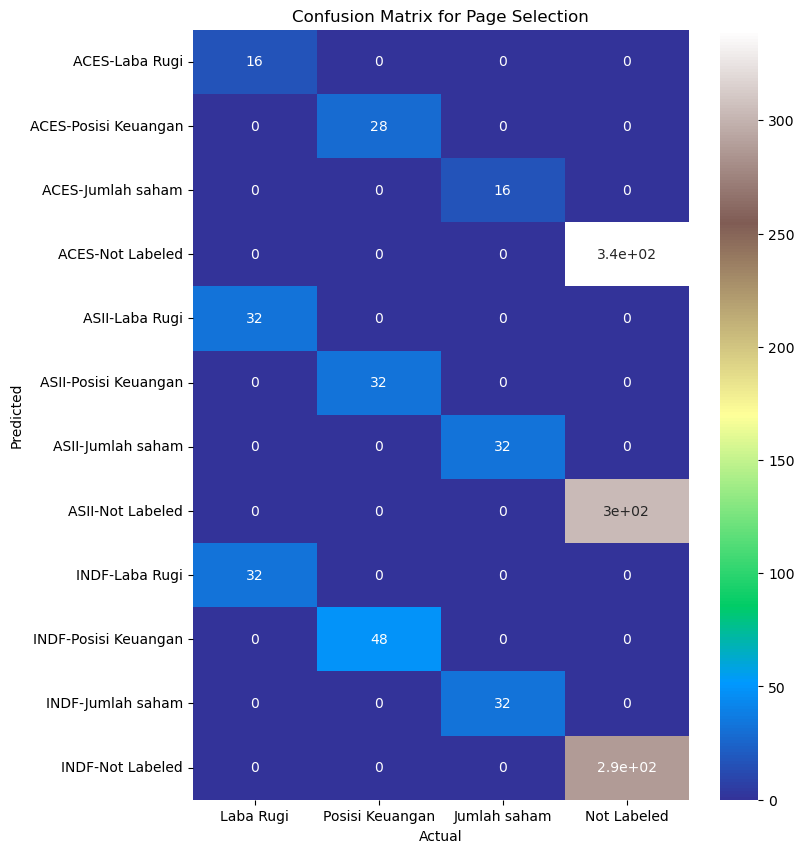

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 10))
sns.heatmap(dfMetrics, annot=True, cmap="terrain")
plt.title("Confusion Matrix for Page Selection")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

In [70]:
jawabanINDF = {key : val for key, val in jawaban.items() if "INDF" in key}

scoreINDF = {}
for key, val in jawabanINDF.items():
    for k in val.keys():
        if k not in scoreINDF.keys():
            scoreINDF[k] = [0, 0]
        if kunci[key][k] == jawabanINDF[key][k]:
            scoreINDF[k][0] += 1
        elif jawabanINDF[key][k] != 'Not Found':
            scoreINDF[k][1] += 1

accuracyINDF = {key : val[0]/len(jawabanINDF) for key, val in scoreINDF.items()}
print("Accuracy : \n{}".format(accuracyINDF))

Accuracy : 
{'pages': 1.0, 'quarter': 1.0, 'year': 1.0, 'unit': 1.0, 'company_name': 0.9375, 'gross_profit': 0.5, 'net_revenue': 0.375, 'ebit': 0.5, 'net_profit': 0.5, 'total_assets': 0.6875, 'total_equity': 0.4375, 'total_current_liabilities': 0.5625, 'total_non_current_liabilities': 0.25, 'total_liabilities': 0.375, 'inventories': 0.9375, 'cash': 0.9375, 'number_of_shares': 0.6875}


In [69]:
totalAccuracy = sum(accuracyASII.values()) / len(accuracyASII)
totalPrecision = sum(precisionASII.values()) / len(precisionASII)

print("Accuracy : {}".format(totalAccuracy))
print("Precision : {}".format(totalPrecision))

Accuracy : 0.99609375
Precision : 0.99609375


In [66]:
jawabanACES = {key : val for key, val in jawaban.items() if "ACES" in key}

scoreACES = {}
for key, val in jawabanACES.items():
    for k in val.keys():
        if k not in scoreACES.keys():
            scoreACES[k] = [0, 0]
        if kunci[key][k] == jawabanACES[key][k]:
            scoreACES[k][0] += 1
        elif jawabanACES[key][k] != 'Not Found':
            scoreACES[k][1] += 1

accuracyACES = {key : val[0]/len(jawabanACES) for key, val in scoreACES.items()}
precisionACES = {key : val[0]/(val[0] + val[1]) for key, val in scoreACES.items()}
print("Accuracy : \n{}".format(accuracyACES))
print("Precision : \n{}".format(precisionACES))

Accuracy : 
{'company_name': 1.0, 'quarter': 1.0, 'year': 1.0, 'unit': 1.0, 'gross_profit': 0.9375, 'net_revenue': 0.9375, 'ebit': 0.875, 'net_profit': 0.9375, 'total_assets': 0.4375, 'inventories': 1.0, 'cash': 1.0, 'total_equity': 1.0, 'total_current_liabilities': 1.0, 'total_non_current_liabilities': 0.9375, 'total_liabilities': 0.875, 'number_of_shares': 0.75}
Precision : 
{'company_name': 1.0, 'quarter': 1.0, 'year': 1.0, 'unit': 1.0, 'gross_profit': 1.0, 'net_revenue': 1.0, 'ebit': 0.9333333333333333, 'net_profit': 1.0, 'total_assets': 1.0, 'inventories': 1.0, 'cash': 1.0, 'total_equity': 1.0, 'total_current_liabilities': 1.0, 'total_non_current_liabilities': 1.0, 'total_liabilities': 1.0, 'number_of_shares': 1.0}


In [68]:
jawabanASII = {key : val for key, val in jawaban.items() if "ASII" in key}

scoreASII = {}
for key, val in jawabanASII.items():
    for k in val.keys():
        if k not in scoreASII.keys():
            scoreASII[k] = [0, 0]
        if kunci[key][k] == jawabanASII[key][k]:
            scoreASII[k][0] += 1
        elif jawabanASII[key][k] != 'Not Found':
            scoreASII[k][1] += 1

accuracyASII = {key : val[0]/len(jawabanASII) for key, val in scoreASII.items()}
precisionASII = {key : val[0]/(val[0] + val[1]) for key, val in scoreASII.items()}
print("Accuracy : \n{}".format(accuracyASII))
print("Precision : \n{}".format(precisionASII))

Accuracy : 
{'company_name': 1.0, 'quarter': 1.0, 'year': 1.0, 'unit': 1.0, 'gross_profit': 1.0, 'net_revenue': 1.0, 'ebit': 1.0, 'net_profit': 1.0, 'total_assets': 1.0, 'inventories': 1.0, 'cash': 1.0, 'total_equity': 1.0, 'total_current_liabilities': 1.0, 'total_non_current_liabilities': 1.0, 'total_liabilities': 1.0, 'number_of_shares': 0.9375}
Precision : 
{'company_name': 1.0, 'quarter': 1.0, 'year': 1.0, 'unit': 1.0, 'gross_profit': 1.0, 'net_revenue': 1.0, 'ebit': 1.0, 'net_profit': 1.0, 'total_assets': 1.0, 'inventories': 1.0, 'cash': 1.0, 'total_equity': 1.0, 'total_current_liabilities': 1.0, 'total_non_current_liabilities': 1.0, 'total_liabilities': 1.0, 'number_of_shares': 0.9375}


In [87]:
import mysql.connector as sql

config = {
    'user': 'admin',
    'password': 'fti-2020',
    'host': '139.255.11.84',
    'database': "TA_Terrence"
#     'auth_plugin':'mysql_native_password'
}

db = sql.connect(**config)

In [83]:
# input -> dictionary 1 LK
def insertToSQL(title, values):
    cursor = db.cursor()
    query = "SELECT * FROM data_laporan WHERE INSTR(id,'{0}')".format(title[:4])
    cursor.execute(query)
    result = cursor.fetchall()
    
    cursor = db.cursor()
    columns = "id,"
    rowValues = ["{}".format(title[:4] + intToStr(len(result)))]
    doubleKey = ['quarter', 'year', 'gross_profit', 'net_revenue', 'ebit', 'net_profit', 'total_assets', 'total_equity', 'total_current_liabilities', 'total_non_current_liabilities', 'total_liabilities', 'inventories', 'cash', 'number_of_shares']
    for key, val in values.items():
        columns += key + ','
        if key in doubleKey:
            rowValues.append(getNumber(val))
        else :
            rowValues.append(val)
    columns += ' del'
    rowValues.append(0)
    query = "INSERT INTO data_laporan ({0}) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)".format(columns)
    print(query)
    print(rowValues)
    cursor.execute(query, rowValues)

    db.commit()

In [22]:
sisaJawaban = {key : val for key,val in jawaban.items() if "ASII" in key}
for key, val in jawaban.items():
    insertToSQL(key, val)

INSERT INTO data_laporan (id,quarter,year,unit,company_name,gross_profit,net_revenue,ebit,net_profit,total_assets,total_equity,total_current_liabilities,total_non_current_liabilities,total_liabilities,inventories,cash,number_of_shares) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
['INDF018', 1.0, 2019.0, 'dalam Jutaan Rupiah', 'Not Found', None, None, None, None, None, None, None, None, None, None, None, 251837500.0]
INSERT INTO data_laporan (id,company_name,quarter,year,unit,inventories,cash,total_current_liabilities,total_liabilities,gross_profit,net_revenue,ebit,net_profit,total_assets,total_equity,total_non_current_liabilities,number_of_shares) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
['INDF019', 'PT Indofood Sukses Makmur Tbk', 2.0, 2019.0, 'dalam Jutaan Rupiah', 11664994.0, 9533244.0, 29845158.0, 46119482.0, None, None, None, None, None, None, None, 663762500.0]
INSERT INTO data_laporan (id,company_name,quarter,yea

In [85]:
def intToStr(num):
    if num + 1 >= 100:
        return str(num + 1)
    if num + 1 >= 10:
        return "0{}".format(num + 1)
    if num + 1 >= 0:
        return "00{}".format(num + 1)        

In [86]:
def getNumber(text):
    text = str(text)
    if text == 'Not Found':
        return None
    text = text.replace('.', '').replace(',', '').replace(' ', '').replace('saham', '')
    return float(text)

In [453]:
getNumber("315.000 saham")

315000.0